<a href="https://colab.research.google.com/github/kmouleejunhyuk/titanic_review/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##캐글의 타이타닉 분석 리뷰
#리더보드 정확도 100% 전처리 기법 사용
#원본: https://www.kaggle.com/imoore/titanic-the-only-notebook-you-need-to-see
#추가로, 다층 FCNN 모델+kfold 구현 연습

In [2]:
#환경
#google colab, pytorch

In [3]:
#구글 드라이브 마운트 & 경로설정
#마운트하기 전, 구글 드라이브의 titanic 폴더에 타이타닉 csv를 업로드해야 합니다
#kaggle 가입 후 데이터를 받을 수 있습니다

from google.colab import drive
drive.mount('/gdrive')

PATH='/gdrive/My Drive/titanic'

Mounted at /gdrive


라이브러리 로드

In [99]:
import pandas as pd
import numpy as np
import re
import os

import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import torch

데이터 로드

In [100]:
full = pd.read_csv(os.path.join(PATH, 'titanic.csv'))

train = full.loc[:int(full.shape[0]*0.8)].copy()
test = full.loc[int(full.shape[0]*0.8):].copy().reset_index(drop=True) 



In [101]:
print(train.head())
print(test.head())

print(train.columns)

   PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0          892         0       3  ...   7.8292   NaN         Q
1          893         1       3  ...   7.0000   NaN         S
2          894         0       2  ...   9.6875   NaN         Q
3          895         0       3  ...   8.6625   NaN         S
4          896         1       3  ...  12.2875   NaN         S

[5 rows x 12 columns]
   PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0         1226         0       3  ...   7.8958   NaN         S
1         1227         0       1  ...  26.0000  C106         S
2         1228         0       2  ...  13.0000   NaN         S
3         1229         0       3  ...   7.2292   NaN         C
4         1230         0       2  ...  31.5000   NaN         S

[5 rows x 12 columns]
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


데이터에 ticket_type라는 변수 추가(이유는 잘 모르겠다)


In [102]:
#원본에서는 pd.DataFrame.apply()를 사용했지만, 속도 개선을 위해 np.vectorize() 사용
train['Ticket_type']=np.vectorize(lambda x: x[0:3])(train['Ticket'])
train['Ticket_type']=train['Ticket_type'].astype('category')
train['Ticket_type']=train['Ticket_type'].cat.codes

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,54
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,67
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,30


In [103]:
test['Ticket_type']=np.vectorize(lambda x: x[0:3])(test['Ticket'])
test['Ticket_type']=test['Ticket_type'].astype('category')
test['Ticket_type']=test['Ticket_type'].cat.codes

test.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,1226,0,3,"Cor, Mr. Ivan",male,27.0,0,0,349229,7.8958,NaN,S,30
1,1227,0,1,"Maguire, Mr. John Edward",male,30.0,0,0,110469,26.0000,C106,S,0
2,1228,0,2,"de Brito, Mr. Jose Joaquim",male,32.0,0,0,244360,13.0000,NaN,S,14


데이터에 이름 길이에 관한 변수 추가

In [104]:
train['Word_count']=np.vectorize(lambda x: len(x.split()))(train['Name'])
test['Word_count']=np.vectorize(lambda x: len(x.split()))(test['Name'])

Cabin 호수 별 변수 추가

In [105]:
#A30-->A-->0
#커스텀
train['Cabin_class']=np.vectorize(lambda x: x[0] if type(x)!=float else 'P')(train['Cabin'])
train['Cabin_class']=train['Cabin_class'].astype('category').cat.codes
test['Cabin_class']=np.vectorize(lambda x: x[0] if type(x)!=float else 'P')(test['Cabin'])
test['Cabin_class']=test['Cabin_class'].astype('category').cat.codes

승객의 선실 보유 여부를 알려주는 변수 추가(nan-->입석?)

In [106]:
train['Has_Cabin']=np.vectorize(lambda x: 0 if type(x)==float else 1)(train['Cabin'])
test['Has_Cabin']=np.vectorize(lambda x: 0 if type(x)==float else 1)(test['Cabin'])

승객의 동승자 수 및 단독 승선 여부 변수 추가

In [107]:
train['Family_size']=train['SibSp'] + train['Parch'] + 1
test['Family_size']=test['SibSp'] + test['Parch'] + 1

In [108]:
train['isalone']=np.vectorize(lambda x: 0 if x>1 else 1)(train['Family_size'])
test['isalone']=np.vectorize(lambda x: 0 if x>1 else 1)(test['Family_size'])

Embarked 변수의 na 제거

In [109]:
train['Embarked']=train['Embarked'].fillna('S')
test['Embarked']=test['Embarked'].fillna('S')

표 가격(Fare)의 중위수로 na 대체 

In [110]:
train['Fare']=train['Fare'].fillna(train['Fare'].median())
test['Fare']=test['Fare'].fillna(test['Fare'].median())

#원본에서는 categoricalfare라는 변수를 만들지만 사용하지 않음

In [111]:
full_data=[train, test]

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



이름에서 mrs, ms등의 의미를 가진 문자를 변수로 생성

In [112]:
def get_title(name):
    title_search=re.search(' ([A-Za-z]+)\.', name)
    if title_search: return title_search.group(1)
    return ""

In [113]:
train['Title']=np.vectorize(get_title)(train['Name'])
test['Title']=np.vectorize(get_title)(test['Name'])

In [114]:
def replace_names(dataset: pd.DataFrame):
    #필요에 따라 확장할 수 있게 함수로 표현
    #오타, 비정형 표현을 변형
    replace_to_rare=['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    replace_by_rule={'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}

    dataset['Title'] = dataset['Title'].replace(replace_to_rare, 'Rare')
    for key, value in replace_by_rule.items():
        dataset['Title'] = dataset['Title'].replace(key, value)
    return None

In [115]:
replace_names(train)
replace_names(test)

Sex, title, fare, embarked, age를 숫자로 매핑

In [116]:
def is_categorical(column, a=train, b=test):
    #카테고리인지 확인
    if np.array_equal(np.unique(a[column].values), np.unique(b[column].values)) & len(np.unique(a[column].values))<30:
        return True
    return False

def mapper(dataset, column):
    map_dict={}
    for idx, key in enumerate(np.unique(dataset[column].values)):
        map_dict[key]=idx

    dataset[column]=dataset[column].map(map_dict).astype(int)

In [117]:
import sys
def range_mapper(dataset, column, c_range: list):
    c_range.insert(0, float('-inf'))
    c_range.append(float('inf'))
    for idx in range(len(c_range)-1):
        dataset.loc[(dataset[column]>c_range[idx]) & (dataset[column]<=c_range[idx+1]), column] = idx
    dataset[column] = dataset[column].astype(int)

In [118]:
if is_categorical('Sex'): 
    mapper(train, 'Sex')
    mapper(test, 'Sex')

if is_categorical('Title'): 
    mapper(train, 'Title')
    mapper(test, 'Title')

if is_categorical('Embarked'): 
    mapper(train, 'Embarked')
    mapper(test, 'Embarked')

In [119]:
range_mapper(train, 'Fare', [7.91, 14.454, 31])
range_mapper(test, 'Fare', [7.91, 14.454, 31])

range_mapper(train, 'Age', [16, 32, 48, 64])
range_mapper(test, 'Age', [16, 32, 48, 64])

사용할 컬럼 외에는 제거한다(Feature_selection)

In [121]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1).astype('int')
test  = test.drop(drop_elements, axis = 1).astype('int')

In [122]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Word_count,Cabin_class,Has_Cabin,Family_size,isalone,Title
0,0,3,1,2,0,0,1,54,3,7,0,1,1,2
1,1,3,0,2,0,0,2,67,5,7,0,2,0,3
2,0,2,1,3,0,1,1,30,4,7,0,1,1,2
3,0,3,1,1,0,1,2,51,3,7,0,1,1,2
4,1,3,0,1,1,1,2,50,6,7,0,3,0,3


In [123]:
test.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Word_count,Cabin_class,Has_Cabin,Family_size,isalone,Title
0,0,3,1,1,0,0,2,30,3,5,0,1,1,2
1,0,1,1,1,0,2,2,0,4,2,1,1,1,2
2,0,2,1,1,0,1,2,14,5,5,0,1,1,2
3,0,3,1,2,2,0,0,18,3,5,0,3,0,2
4,0,2,1,1,0,3,2,43,3,5,0,1,1,2


피어슨 상관계수 시각화

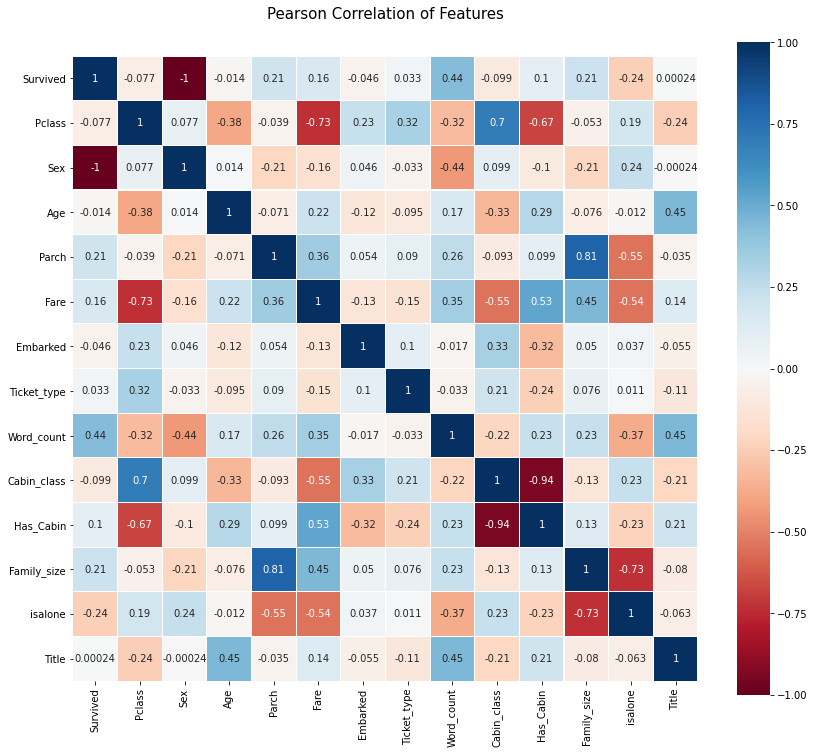

In [127]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
#sex와 survived, has_cabin과 cabin_class가 너무 강하게 연관됨. 개선이 필요
#전처리 끝